In [14]:
import matplotlib.pyplot as plt
from pathlib import Path
from segmentflow import segment, view, mesh
from skimage import color, draw, exposure, feature, filters, transform, util
from tqdm import tqdm
import sys
import numpy as np

In [15]:
def find_average_edges(imgs):
    img_avg = np.mean(imgs, axis=0)
    # Calc semantic seg threshold values and generate histogram
    threshold = filters.threshold_minimum(img_avg)
    # Segment images with threshold values
    img_avg_bw = segment.isolate_classes(img_avg, threshold, intensity_step=255)
    # Detect edges in image
    edges = feature.canny(img_avg_bw, sigma=2.0)
    return edges

def fit_circle_to_edges(edge_img):
    # Perform a Hough Transform
    hough_radii = np.arange(edge_img.shape[0] // 4, edge_img.shape[0]//2, 2)
    hspaces = transform.hough_circle(edge_img, hough_radii)
    results = transform.hough_circle_peaks(hspaces, hough_radii, num_peaks=1)
    accum, center_x, center_y, radius = [row[0] for row in results]
    return center_x, center_y, radius

def create_radial_filter(img, center_x, center_y, radius):
    radial_filter = np.zeros_like(img)
    for r_sub in np.arange(0, radius)[::-1]:
        # Draw circle
        circ_rows, circ_cols = draw.circle_perimeter(
            center_y, center_x, radius - r_sub, shape=img.shape)
        # Get the average of the 50 largest values
        circ_avg_max = np.median(
            [
                img[circ_rows, circ_cols][i]
                for i in np.argsort(-img[circ_rows, circ_cols])[:50]
            ]
        )
        radial_filter[circ_rows, circ_cols] = circ_avg_max
    radial_filter = filters.median(radial_filter)
    radial_filter[radial_filter == 0] = np.median(img)
    return radial_filter

In [16]:
WORKFLOW_DESCRIPTION = (
    'This workflow segments IDOX particles from a binder in CT scans of'
    ' of pressed pucks taken with the CSM Zeiss Versa x-ray source.'
    ' Manual thresholds are set for semantic segmentation.'
    ' The output can be labeled voxels following semantic segmentation or'
    ' instance segmentation, and/or STL files corresponding to each'
    ' instance-segmented particle.'
    ' Developed for Segmentflow v0.0.3.'
)

CATEGORIZED_INPUT_SHORTHANDS = {
    'A. Input' : {
        'in_dir_path'  : '01. Input dir path',
        'file_suffix'  : '02. File suffix',
        'slice_crop'   : '03. Slice crop',
        'row_crop'     : '04. Row crop',
        'col_crop'     : '05. Column crop',
        'spatial_res'  : '06. Pixel size',
    },
    'B. Output' : {
        'out_dir_path'      : '01. Path to save output dir',
        'overwrite'         : '02. Overwrite files',
        'out_prefix'        : '03. Output prefix',
        'slices'            : '04. Specify slices to plot',
        'nslices'           : '05. Number of slices in checkpoint plots',
        'save_stls'         : '06. Save STL files',
        'suppress_save_msg' : '07. Suppress save message for each STL file',
        'save_voxels'       : '08. Save voxel TIF stack'
    },
    'C. Preprocessing' : {
        'pre_seg_rad_filter' : '01. Apply radial filter',
        'pre_seg_med_filter' : '02. Apply median filter',
        'rescale_range'      : '03. Range for rescaling intensity (percentile)',
    },
    'D. Segmentation' : {
        'thresh_vals'       : '01. Threshold values for semantic segmentation',
        'thresh_hist_ylims' : '02. Upper and lower y-limits of histogram',
        'fill_holes'        : '03. Fill holes in semantic segmentation',
        'min_vol'           : '04. Min particle volume saved (voxels)',
        'perform_seg'       : '05. Perform instance segmentation',
        'min_peak_dist'     :
            '06. Min distance between region centers (pixels)',
        'exclude_borders'   : '07. Exclude border particles',
    },
    'E. Surface Meshing' : {
        'n_erosions'           : '01. Number of pre-surface meshing erosions',
        'post_seg_med_filter'  : '02. Smooth voxels with median filtering',
        'voxel_step_size'      : '03. Marching cubes voxel step size',
        'mesh_smooth_n_iters'  : '04. Number of smoothing iterations',
        'mesh_simplify_n_tris' : '05. Target number of triangles/faces',
        'mesh_simplify_factor' : '06. Simplification factor per iteration',
    },
}

DEFAULT_VALUES = {
    'in_dir_path'          : 'REQUIRED',
    'file_suffix'          : 'tiff',
    'slice_crop'           : None,
    'row_crop'             : None,
    'col_crop'             : None,
    'spatial_res'          : 1,
    'out_dir_path'         : 'REQUIRED',
    'out_prefix'           : '',
    'overwrite'            : False,
    'nslices'              : 4,
    'slices'               : None,
    'save_stls'            : True,
    'suppress_save_msg'    : True,
    'save_voxels'          : False,
    'pre_seg_rad_filter'   : False,
    'pre_seg_med_filter'   : False,
    'rescale_range'        : None,
    'thresh_vals'          : [30000, 62000],
    'thresh_hist_ylims'    : [0, 2e7],
    'fill_holes'           : False,
    'min_vol'              : None,
    'perform_seg'          : True,
    'min_peak_dist'        : 6,
    'exclude_borders'      : False,
    'n_erosions'           : 0,
    'post_seg_med_filter'  : False,
    'voxel_step_size'      : 1,
    'mesh_smooth_n_iters'  : None,
    'mesh_simplify_n_tris' : None,
    'mesh_simplify_factor' : None,
}

# Notebook edits
WORKFLOW_NAME = "IDOX_pours"
input_path = (
    r'C:\Users\gusb\Research\segmentflow\input_files\IDOX_pucks_input.yml')
argv = ['-i', input_path]
show_checkpoints = True
checkpoint_save_dir = None

#-----------------------------------------------------#
# Get command-line arguments and read YAML input file #
#-----------------------------------------------------#
ui = segment.process_args(
    argv, WORKFLOW_NAME, WORKFLOW_DESCRIPTION, CATEGORIZED_INPUT_SHORTHANDS,
    DEFAULT_VALUES)
show_checkpoints = False
checkpoint_save_dir = ui['out_dir_path']

## Load images


Loading images...
--> Images loaded as 3D array:  (468, 512, 501)
float32
-0.0021225412 0.013517095
Converting to 16-bit...
uint16
0 886


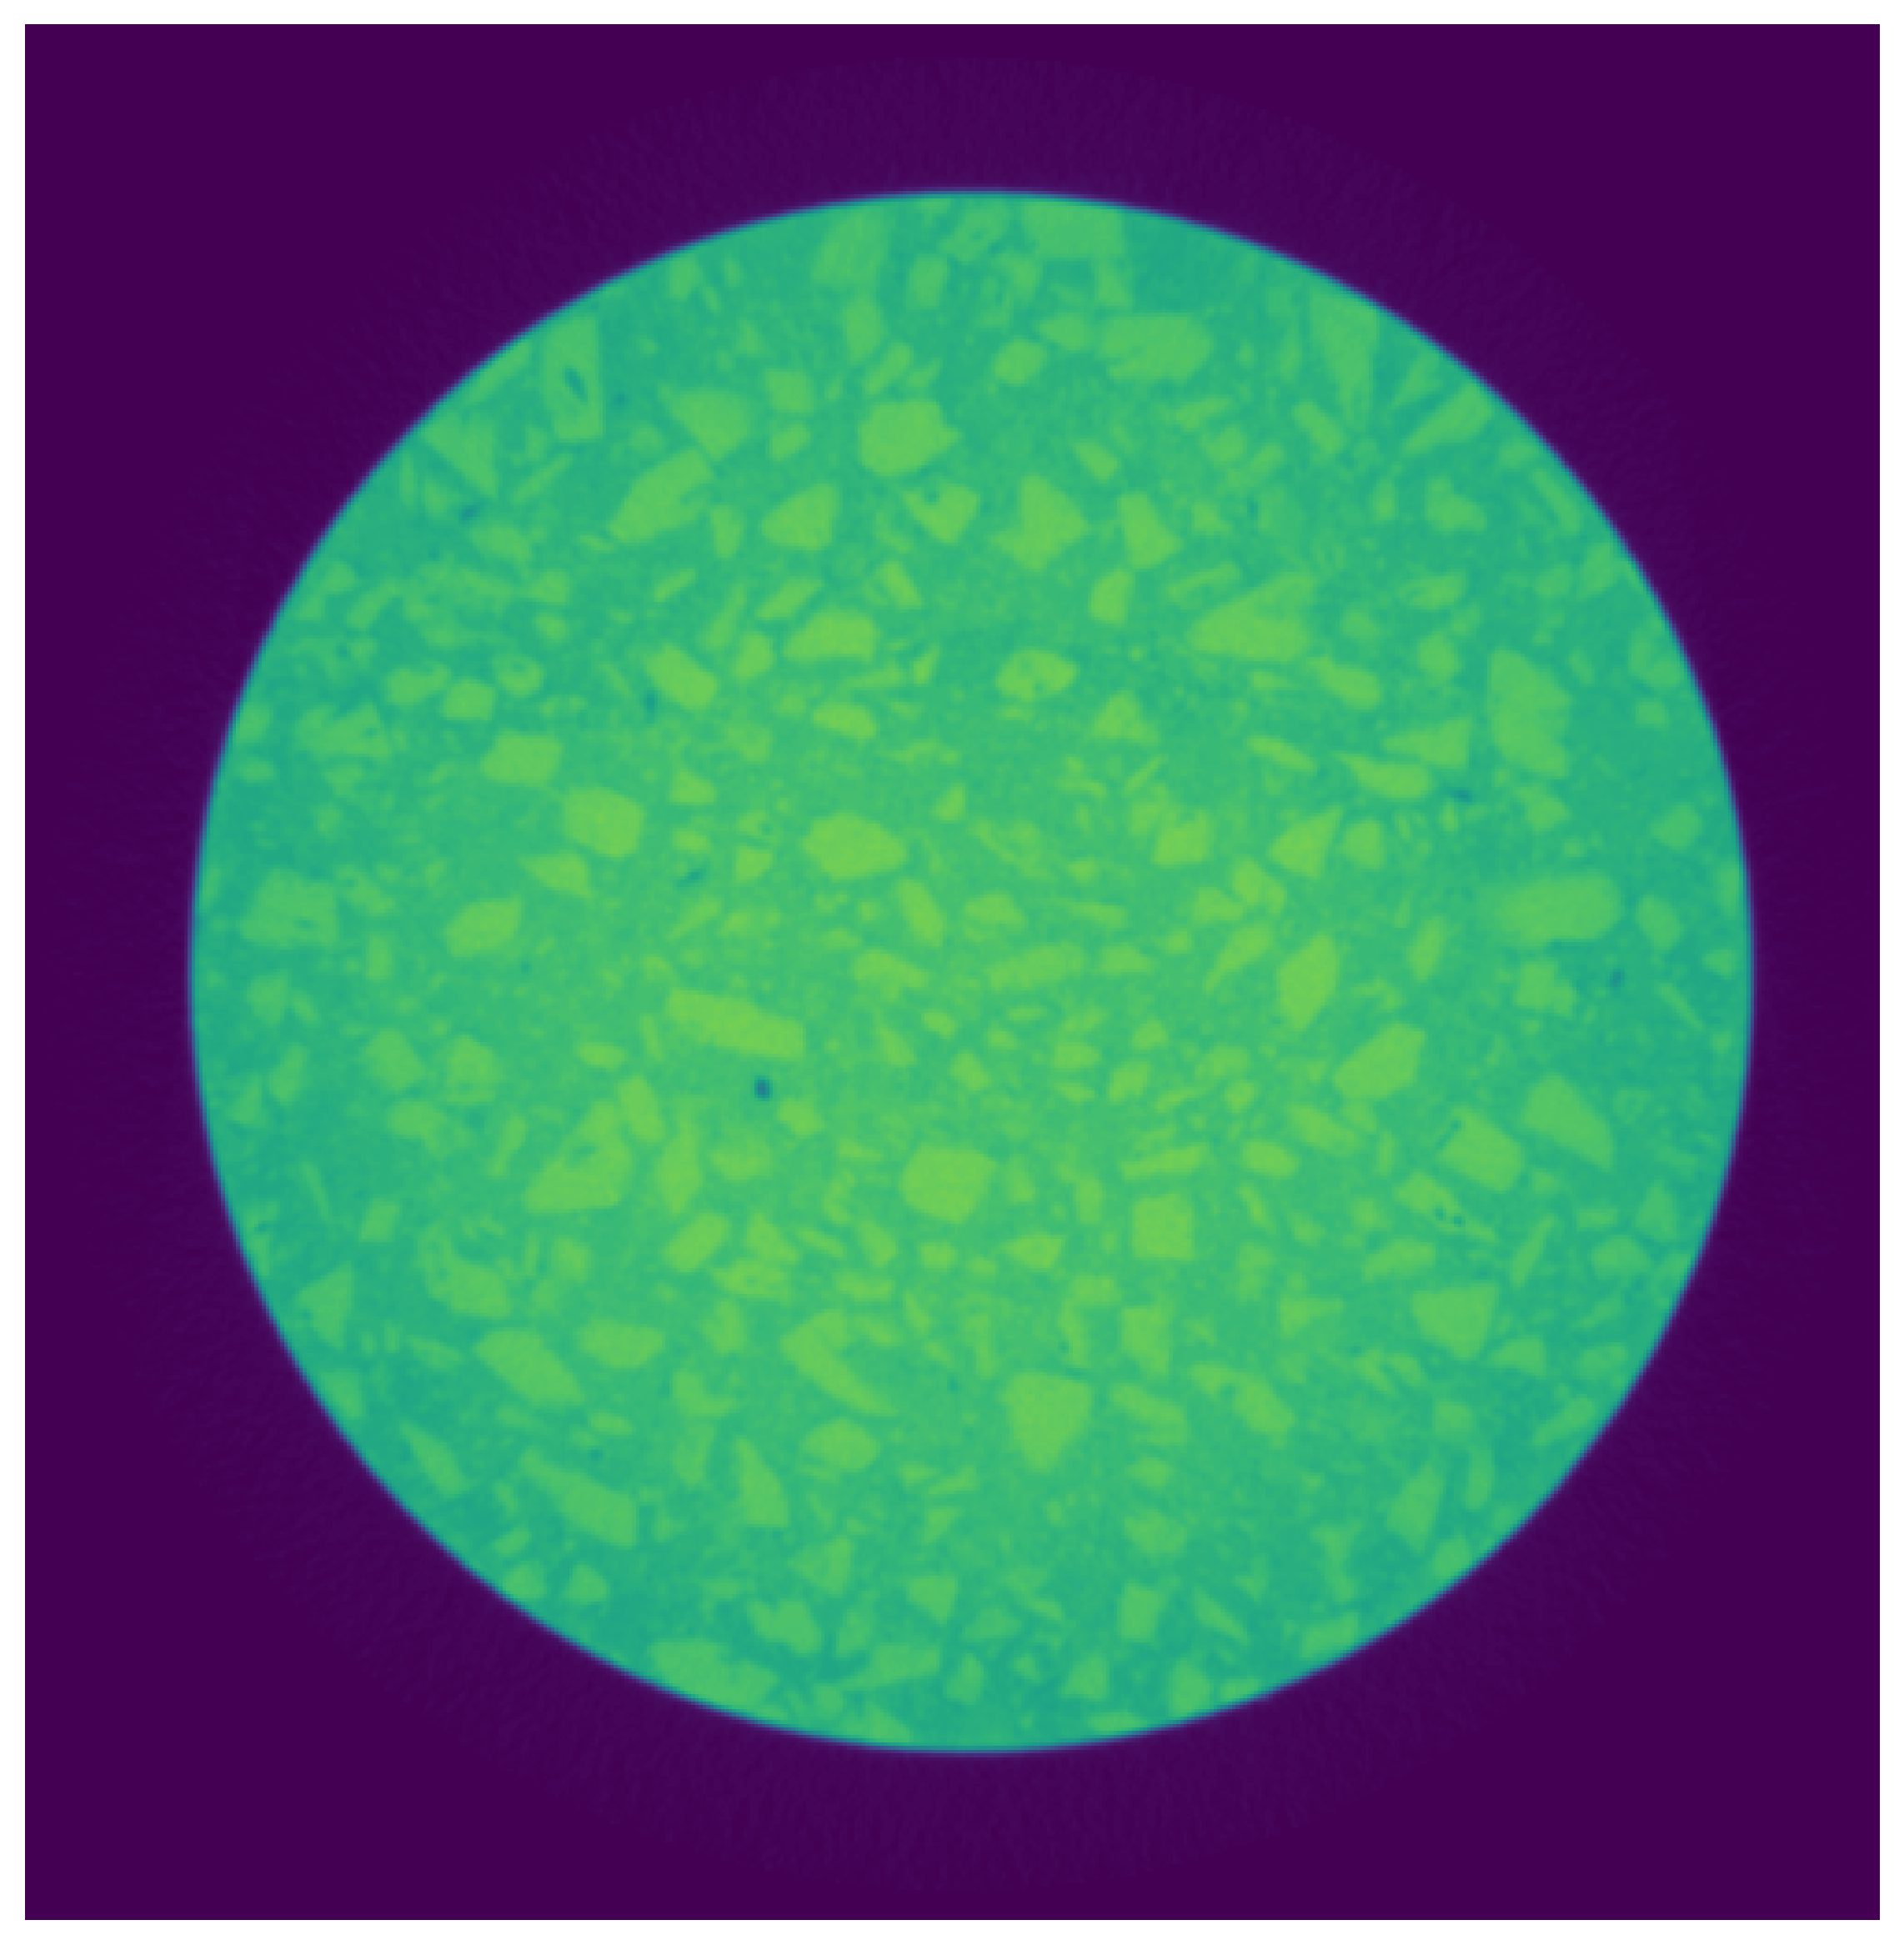

In [17]:
#-------------#
# Load images #
#-------------#
print()
imgs = segment.load_images(
    ui['in_dir_path'],
    slice_crop=ui['slice_crop'],
    row_crop=ui['row_crop'],
    col_crop=ui['col_crop'],
    convert_to_float=True,
    file_suffix=ui['file_suffix']
)
print(imgs.dtype)
print(imgs.min(), imgs.max())
print('Converting to 16-bit...')
imgs = util.img_as_uint(imgs)
print(imgs.dtype)
print(imgs.min(), imgs.max())
# Generate raw imgs viz
fig, axes = view.vol_slices(
        imgs,
        slices=ui['slices'],
        nslices=ui['nslices'],
        print_slices=False,
        fig_w=7.5,
        dpi=300
    )
fig_n = 0
segment.output_checkpoints(
    fig, show=show_checkpoints, save_path=checkpoint_save_dir,
    fn_n=fig_n, fn_suffix='raw-imgs')

## Radial filter

255


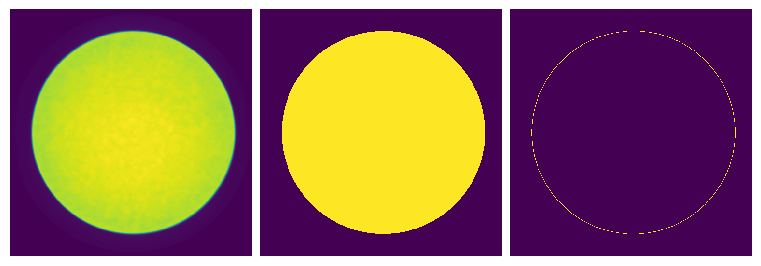

In [18]:
img_avg = np.mean(imgs, axis=0)
# Calc semantic seg threshold values and generate histogram
threshold = filters.threshold_minimum(img_avg)
# Segment images with threshold values
img_avg_bw = segment.isolate_classes(img_avg, threshold, intensity_step=255)
print(img_avg_bw.max())
# Detect edges in image
edges = feature.canny(img_avg_bw)
# edges = feature.canny(img_avg_bw, sigma=2.0, low_threshold=0.01*img_avg.max())
# edges = feature.canny(img_avg_bw.astype(np.uint8))
fig, ax = view.images([img_avg, img_avg_bw, edges])
plt.show()

### Fit circle to edge

Fitting circle to edges...
0.0 547.7895299145299
0.0 1.0


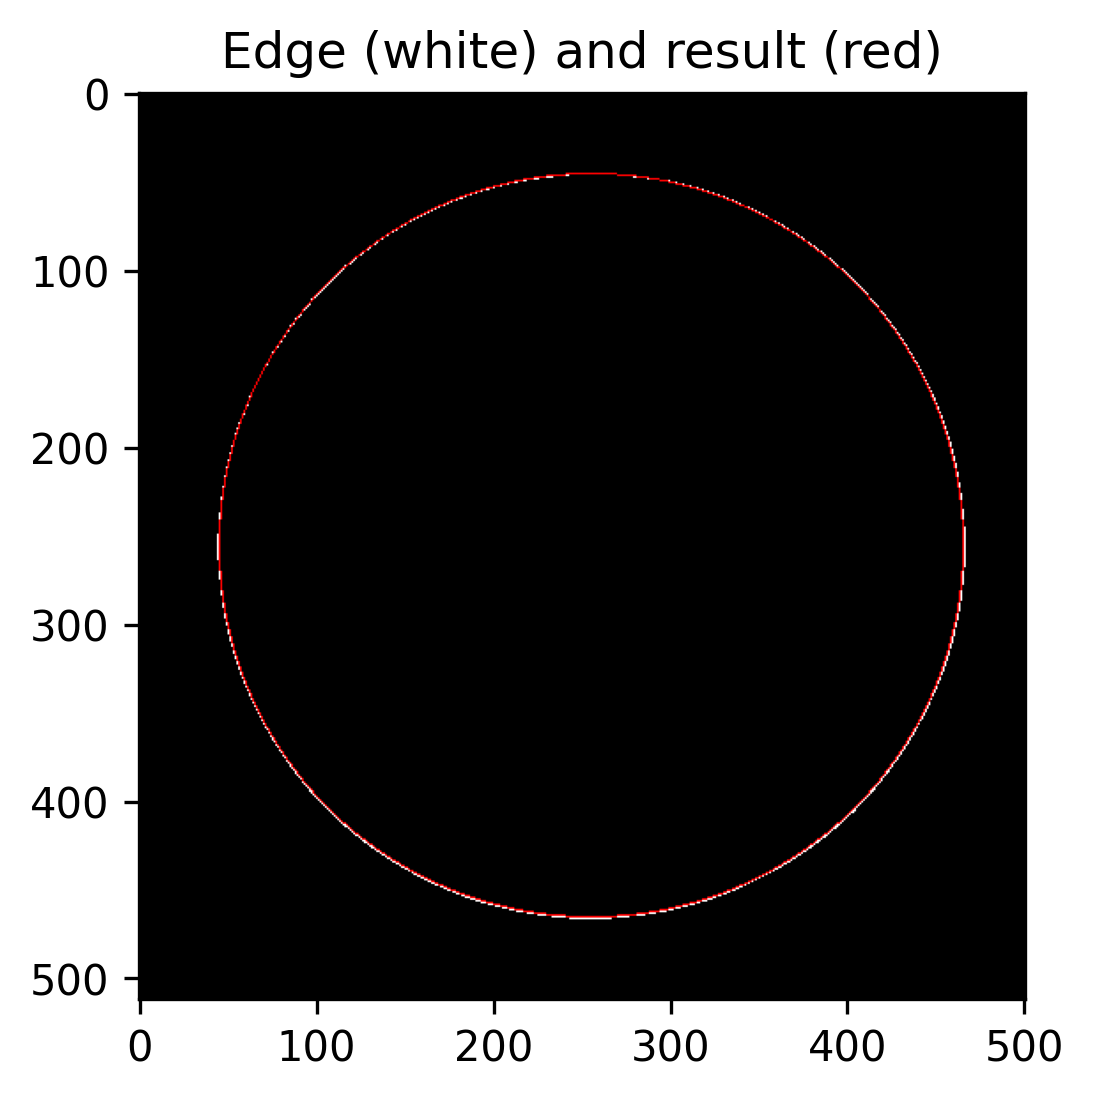

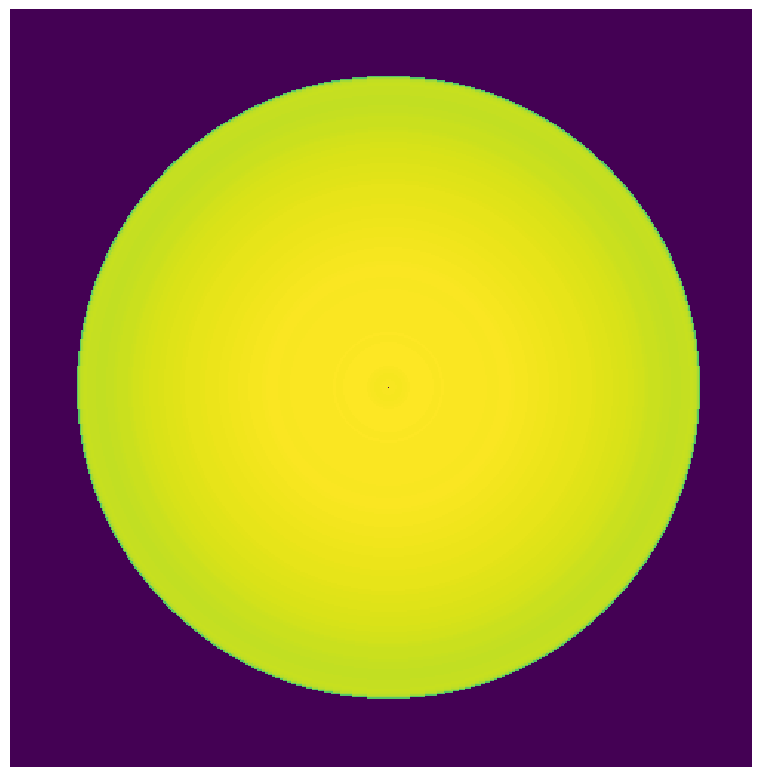

In [19]:
print('Fitting circle to edges...')
cx, cy, r = fit_circle_to_edges(edges)
# Draw circle
rows, cols = draw.circle_perimeter(cy, cx, r, shape=edges.shape)
edges_rgb = color.gray2rgb(util.img_as_ubyte(edges))
edges_rgb[rows, cols] = (255, 0, 0)
fig, ax = plt.subplots(dpi=300)
ax.set_title('Edge (white) and result (red)')
ax.imshow(edges_rgb)
fig_n += 1
segment.output_checkpoints(
    fig, show=show_checkpoints, save_path=checkpoint_save_dir,
    fn_n=fig_n, fn_suffix='fitted-circle')
n_imgs = imgs.shape[0]
# img = imgs[n_imgs//2, ...]
img = img_avg
img_radial = np.zeros_like(img)
for r_sub in np.arange(0, r)[::-1]:
    # Draw circle
    circ_rows, circ_cols = draw.circle_perimeter(
        cy, cx, r - r_sub, shape=img.shape)
    # Get the average of the 50 largest values
    circ_avg_max = np.median(
        [
            img[circ_rows, circ_cols][i]
            for i in np.argsort(-img[circ_rows, circ_cols])[:50]
        ]
    )
    img_radial[circ_rows, circ_cols] = circ_avg_max
print(img_radial.min(), img_radial.max())
img_radial = exposure.rescale_intensity(img_radial)
print(img_radial.min(), img_radial.max())
img_radial = filters.median(img_radial)
fig, ax = view.images(img_radial)
fig_n += 1
segment.output_checkpoints(
    fig, show=show_checkpoints, save_path=checkpoint_save_dir,
    fn_n=fig_n, fn_suffix='img-radial')

### Apply radial filter

imgs: 0, 65535
img: 0, 65535
np.median(img)=51343.0
img_radial: 0.0, 0.9996547897435498
img_rad: 0, 65512
img_rad: 48620, 65512
img_rad: 48620, 65512
img_filt: 0.0, 59093.0
img_filt: 0, 59093
uint16
uint16
uint16
uint16


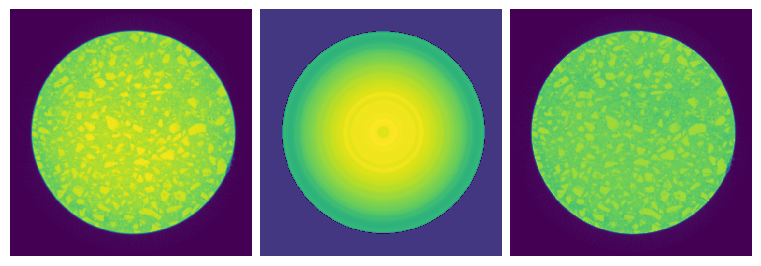

In [29]:
minmax = lambda x: f'{x.min()}, {x.max()}'
# Radial filter
n_imgs = imgs.shape[0]
print('imgs:', minmax(imgs))
img = imgs[n_imgs//2, ...]
img = exposure.rescale_intensity(img)
img = util.img_as_uint(img)
print('img:', minmax(img))
print(f'{np.median(img)=}')
print('img_radial:', minmax(img_radial))
# img_rad = exposure.rescale_intensity(img_radial)
img_rad = util.img_as_uint(img_radial)
print('img_rad:', minmax(img_rad))
img_rad[img_rad == 0] = np.median(img)
print('img_rad:', minmax(img_rad))
print('img_rad:', minmax(img_rad))
img_filt = img / img_rad * np.median(img)
print('img_filt:', minmax(img_filt))
img_filt = img_filt.astype(np.uint16)
print('img_filt:', minmax(img_filt))
fig, axes = view.images([img, img_rad, img_filt])
print(imgs.dtype)
print(img.dtype)
print(img_rad.dtype)
print(img_filt.dtype)
plt.show()

In [21]:
print(f'{imgs.dtype=}')
print('imgs:', minmax(imgs))
imgs = exposure.rescale_intensity(imgs)
print(f'{imgs.dtype=}')
print('imgs:', minmax(imgs))

imgs.dtype=dtype('uint16')
imgs: 0, 886
imgs.dtype=dtype('uint16')
imgs: 0, 65535


--> Plotting image: 200


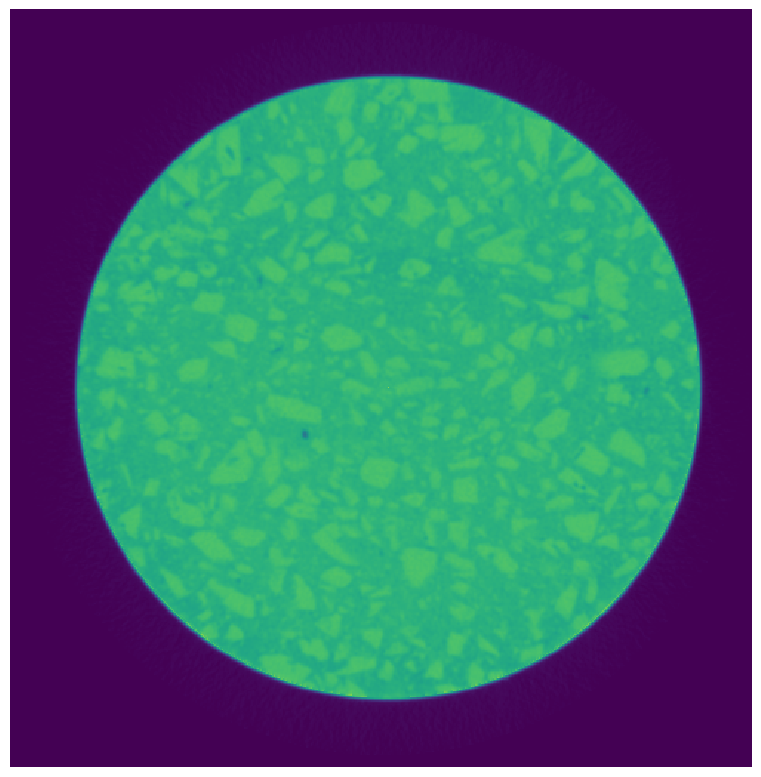

In [32]:
# Calculate radial filter
img_rad = util.img_as_uint(img_radial)
img_rad[img_rad == 0] = np.median(img)
# Apply radial filter
total_med = np.median(imgs)
imgs_rad_filt = np.stack([
    (imgs[i, ...] / img_rad * total_med).astype(np.uint16)
    for i in range(imgs.shape[0])
])
# imgs = np.stack(imgs_rad_filt)
# imgs_rad_filt = None
fig, ax = view.vol_slices(imgs_rad_filt, slices=ui['slices'])
fig_n += 1
segment.output_checkpoints(
    fig, show=show_checkpoints, save_path=checkpoint_save_dir,
    fn_n=fig_n, fn_suffix='radial-filtered')

In [35]:
test = np.zeros((3,3), dtype=np.uint8)
print(test.dtype)

dtype('uint8')

In [41]:
def radial_filter(imgs):
    print('--> Fitting circle to edges...')
    cx, cy, r = fit_circle_to_edges(edges)
    # Draw circle
    rows, cols = draw.circle_perimeter(cy, cx, r, shape=edges.shape)
    edges_rgb = color.gray2rgb(util.img_as_ubyte(edges))
    edges_rgb[rows, cols] = (255, 0, 0)
    n_imgs = imgs.shape[0]
    img_radial = np.zeros_like(img_avg)
    for r_sub in np.arange(0, r)[::-1]:
        # Draw circle
        circ_rows, circ_cols = draw.circle_perimeter(
            cy, cx, r - r_sub, shape=img_avg.shape)
        # Get the average of the 50 largest values
        circ_avg_max = np.median(
            [
                img_avg[circ_rows, circ_cols][i]
                for i in np.argsort(-img_avg[circ_rows, circ_cols])[:50]
            ]
        )
        img_radial[circ_rows, circ_cols] = circ_avg_max
    img_radial = exposure.rescale_intensity(img_radial)
    # Apply median filter to fill gaps between imperfect concentric circles
    img_radial = filters.median(img_radial)
    # img_rad = util.img_as_uint(img_radial)
    total_med = np.median(imgs)
    img_radial[img_radial == 0] = total_med
    imgs_rad_filt = np.stack([
        # (imgs[i, ...] / img_radial * total_med).astype(np.uint16)
        imgs[i, ...] / img_radial * total_med
        for i in range(imgs.shape[0])
    ])
    if imgs.dtype == np.dtype('uint16'):
        print(f'--> Converting to 16-bit...')
        imgs_rad_filt = exposure.rescale_intensity(imgs_rad_filt)
        imgs_rad_filt = util.img_as_uint(imgs_rad_filt)
    return imgs_rad_filt

imgs.dtype=dtype('uint16')
--> Fitting circle to edges...
--> Converting to 16-bit...
imgs_rad_filt.dtype=dtype('uint16')
--> Plotting images: [100, 200, 300]
--> Plotting images: [100, 200, 300]


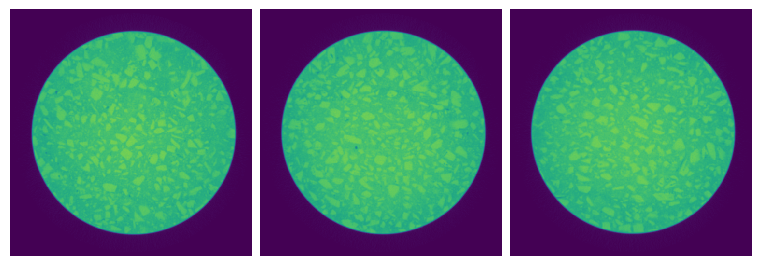

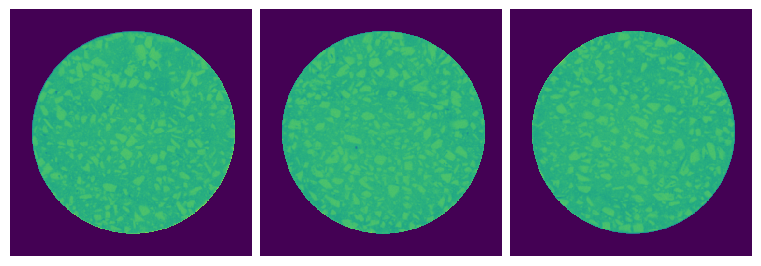

In [42]:
print(f'{imgs.dtype=}')
imgs_rad_filt = radial_filter(imgs)
print(f'{imgs_rad_filt.dtype=}')
slices = [100, 200, 300]
fig, axes = view.vol_slices(imgs, slices=slices)
fig, axes = view.vol_slices(imgs_rad_filt, slices=slices)
plt.show()